In [1]:
import pandas as pd
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from scipy.sparse import coo_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline  
import matplotlib.pyplot as plt


In [2]:
trainBodies = pd.read_csv('/home/virajp/ADM/dataset/train_bodies.csv')
trainStances = pd.read_csv('/home/virajp/ADM/dataset/train_stances.csv')
trainStancesRandom = pd.read_csv('/home/virajp/ADM/dataset/train_stances.random.csv')
trainStances.head()
#trainBodies.head(5) + trainStances.head(5)

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [3]:
unrelatedCount = trainStances[trainStances["Stance"] == "unrelated"].count()[0]
agreeCount = trainStances[trainStances["Stance"] == "agree"].count()[0]
disagreeCount = trainStances[trainStances["Stance"] == "disagree"].count()[0]
discussCount = trainStances[trainStances["Stance"] == "discuss"].count()[0]
totalCount = trainStances.count()[0]

print("Total is ", totalCount)
print("Unrelated: ",unrelatedCount, float(unrelatedCount) / totalCount)
print("Disagree: ",disagreeCount, float(disagreeCount) / totalCount)
print("Agree: ",agreeCount, float(agreeCount) / totalCount)
print("Discuss: ",discussCount,  float(discussCount) / totalCount)

('Total is ', 49972)
('Unrelated: ', 36545, 0.7313095333386697)
('Disagree: ', 840, 0.016809413271432)
('Agree: ', 3678, 0.07360121668134155)
('Discuss: ', 8909, 0.1782798367085568)


In [4]:
trainStancesRandom.head(100)

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,discuss
1,Hundreds of Palestinians flee floods in Gaza a...,158,discuss
2,"Christian Bale passes on role of Steve Jobs, a...",137,disagree
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,disagree
4,Spider burrowed through tourist's stomach and ...,1923,agree
5,'Nasa Confirms Earth Will Experience 6 Days of...,154,discuss
6,Accused Boston Marathon Bomber Severely Injure...,962,unrelated
7,Identity of ISIS terrorist known as 'Jihadi Jo...,2033,agree
8,Banksy 'Arrested & Real Identity Revealed' Is ...,1739,agree
9,British Aid Worker Confirmed Murdered By ISIS,882,agree


In [5]:
limit = len(trainStances)
#limit = 1000
strip = True
lowercase = True
print limit

49972


In [6]:
print "Train Stances (20/%s):" % (len(trainStances))
trainStances.head(20)

trainStances["unrelated"] = trainStances["Stance"].apply(lambda x: 1 if x == "unrelated" else 0)
trainStances["agree"] = trainStances["Stance"].apply(lambda x: 1 if x == "agree" else 0)
trainStances["disagree"] = trainStances["Stance"].apply(lambda x: 1 if x == "disagree" else 0)
trainStances["discuss"] = trainStances["Stance"].apply(lambda x: 1 if x == "discuss" else 0)
trainStances["Body"] = [""] * len(trainStances)
for index, row in trainStances[0:limit].iterrows():
    trainStances.loc[index, "Body"] = trainBodies[trainBodies['Body ID'] == row["Body ID"]]['articleBody'].item()


def preprocess(text, lowercase, strip):
    text = text.lower() if lowercase else text
    text = " ".join(re.findall("[a-zA-Z]+", text)) if strip else text
    return text

if strip or lowercase:
    trainStances["Body"]= trainStances["Body"].apply(lambda x: preprocess(x,lowercase,strip))
    trainStances["Headline"]= trainStances["Headline"].apply(lambda x: preprocess(x,lowercase,strip))
    

trainStances = trainStances.drop("Body ID", 1)
trainStances = trainStances.drop("Stance", 1)
    
trainStances.head()

Train Stances (20/49972):


,Headline,unrelated,agree,disagree,discuss,Body
0,police find mass graves with at least bodies n...,1,0,0,0,danny boyle is directing the untitled film set...
1,hundreds of palestinians flee floods in gaza a...,0,1,0,0,hundreds of palestinians were evacuated from t...
2,christian bale passes on role of steve jobs ac...,1,0,0,0,year old moscow resident was hospitalized with...
3,hbo and apple in talks for month apple tv stre...,1,0,0,0,reuters a canadian soldier was shot at the can...
4,spider burrowed through tourist s stomach and ...,0,0,1,0,fear not arachnophobes the story of bunbury s ...


In [7]:
trainStances.head(100)

,Headline,unrelated,agree,disagree,discuss,Body
0,police find mass graves with at least bodies n...,1,0,0,0,danny boyle is directing the untitled film set...
1,hundreds of palestinians flee floods in gaza a...,0,1,0,0,hundreds of palestinians were evacuated from t...
2,christian bale passes on role of steve jobs ac...,1,0,0,0,year old moscow resident was hospitalized with...
3,hbo and apple in talks for month apple tv stre...,1,0,0,0,reuters a canadian soldier was shot at the can...
4,spider burrowed through tourist s stomach and ...,0,0,1,0,fear not arachnophobes the story of bunbury s ...
5,nasa confirms earth will experience days of to...,0,1,0,0,thousands of people have been duped by a fake ...
6,accused boston marathon bomber severely injure...,1,0,0,0,a british fighter who travelled to iraq to sto...
7,identity of isis terrorist known as jihadi joh...,1,0,0,0,adding to apple s ios launch troubles a report...
8,banksy arrested real identity revealed is the ...,0,1,0,0,if you ve seen a story floating around on your...
9,british aid worker confirmed murdered by isis,1,0,0,0,the british islamic state militant who has fea...


In [8]:
print "Train Stances Random (20/%s)" % (len(trainStancesRandom))
trainStancesRandom.head(20)

Train Stances Random (20/49972)


,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,discuss
1,Hundreds of Palestinians flee floods in Gaza a...,158,discuss
2,"Christian Bale passes on role of Steve Jobs, a...",137,disagree
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,disagree
4,Spider burrowed through tourist's stomach and ...,1923,agree
5,'Nasa Confirms Earth Will Experience 6 Days of...,154,discuss
6,Accused Boston Marathon Bomber Severely Injure...,962,unrelated
7,Identity of ISIS terrorist known as 'Jihadi Jo...,2033,agree
8,Banksy 'Arrested & Real Identity Revealed' Is ...,1739,agree
9,British Aid Worker Confirmed Murdered By ISIS,882,agree


In [9]:
# build feature vocabulary
ngram = 3

vectorizer = CountVectorizer(ngram_range=(1, ngram))
trainStances["Number Of Common Words"] = [-1 for x in range(len(trainStances))]
trainStances["Number Of Words In Body"] = [-1 for x in range(len(trainStances))]
trainStances["Number Of Words In Headline"] = [-1 for x in range(len(trainStances))]

for index, row in trainStances[0:limit].iterrows():
    headline = row['Headline']
    body = row['Body']
    
#     print index
#     print "HEADLINE: \n%s\n" % headline
#     print "BODY: \n%s\n" % body

    headline_words = headline.split()
    body_words = body.split()
    
    num_words_in_common = len(set(headline_words).intersection(body_words))
    
    trainStances.loc[index, "Number Of Common Words"] = num_words_in_common  
    trainStances.loc[index, "Number Of Words In Body"] = len(body_words) 
    trainStances.loc[index, "Number Of Words In Headline"] = len(headline_words) 

trainStances.head()

# I'd like to graph the num_words_in_common integer to the stance classification, to see what kind of correlation we're working with here.

,Headline,unrelated,agree,disagree,discuss,Body,Number Of Common Words,Number Of Words In Body,Number Of Words In Headline
0,police find mass graves with at least bodies n...,1,0,0,0,danny boyle is directing the untitled film set...,2,198,17
1,hundreds of palestinians flee floods in gaza a...,0,1,0,0,hundreds of palestinians were evacuated from t...,10,429,11
2,christian bale passes on role of steve jobs ac...,1,0,0,0,year old moscow resident was hospitalized with...,4,187,17
3,hbo and apple in talks for month apple tv stre...,1,0,0,0,reuters a canadian soldier was shot at the can...,2,79,14
4,spider burrowed through tourist s stomach and ...,0,0,1,0,fear not arachnophobes the story of bunbury s ...,9,627,11


In [13]:
trainStances.to_csv('cleaned_globaldata.csv',index=False)

{'unrelated': 2.5712135723081131, 'disagree': 7.2666666666666666, 'discuss': 7.3855651588281512, 'agree': 7.6375747688961395}


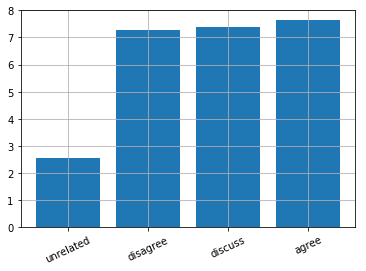

In [11]:
categoryNumberOfCommonWordsMeans = { "unrelated":0, "discuss":0, "agree":0, "disagree":0}
for category in categoryNumberOfCommonWordsMeans: #for each category calculate the mean number of words in common between header and body 
    categoryNumberOfCommonWordsMeans[category] = trainStances[0:limit][trainStances[category] == 1].mean()["Number Of Common Words"]

print(categoryNumberOfCommonWordsMeans)

values = [] #in same order as traversing keys
keys = [] #also needed to preserve order
for key in categoryNumberOfCommonWordsMeans.keys():
  keys.append(key)
  values.append(categoryNumberOfCommonWordsMeans[key])
    
l = plt.bar(range(len(values)), values,align='center')
plt.xticks(range(len(keys)), keys, rotation=25)
plt.grid(True)

In [36]:
bodies = [x for x in trainStances[0:limit]["Body"]]
headlines = [x for x in trainStances[0:limit]["Headline"]]

# could make count vectors for each type
bodyBOWVectors = cv.transform(bodies)
headlineBOWVectors = cv.transform(headlines)

print("Size:", headlineBOWVectors.shape, "same" if bodyBOWVectors.shape==headlineBOWVectors.shape else "DIFFERENT!!!")

combinedVectors = bodyBOWVectors.multiply(headlineBOWVectors)

('Size:', (49972, 644727), 'same')


In [38]:
headlineBOWVectors.shape

(49972, 644727)

In [39]:
bodyBOWVectors.shape


(49972, 644727)

In [34]:
cv=CountVectorizer()

cv=TfidfVectorizer(ngram_range=(1,3))
cv.fit(bodies + headlines)

def featurize(xs):
    bodyVector = cv.transform([a for a in xs["Body"]])
    hlVector = cv.transform([a for a in xs["Headline"]])
    
    # maybe its better to have one vector where the presence of the word is scaled
    # up if that word is present in the headline, otherwise scaled down 
    # something of the form, but scaled with constants...
    combinedVectors = bodyVector.multiply(hlVector)
    
    numberOfWords = [[a] for a in xs["Number Of Common Words"]]
    
    return hstack([bodyVector,hlVector,combinedVectors, numberOfWords])

In [35]:
x_train = featurize(trainStances[0:limit])
y_train = list([y for y in trainStances[0:limit]["unrelated"]])

clf = LogisticRegression()
#run cross validation to get a good accuracy measure
scores = cross_val_score(clf, x_train, y_train, cv=5)

#now fit the model 
clf.fit(x_train, y_train)
# compute a confusion matrix for test accuracy
conf = confusion_matrix(y_train, clf.predict(x_train))

print "Crossvalidation", scores, ("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Coefficient for number of words is ", clf.coef_[0][-1])

print("Training error predicted postive rate:", sum(clf.predict(x_train)) / 1000.)
print("Training error false positive", conf[0][1] / float(limit))
print("Training error false negative", conf[1][0]/ float(limit))
print("Training error true positive", conf[1][1]/ float(limit))
print("Training error true negative", conf[0][0]/ float(limit))


Crossvalidation [ 0.96238119  0.96478239  0.96627977  0.96567941  0.96888133] Accuracy: 0.97 (+/- 0.00)
('Coefficient for number of words is ', -1.2295712411434183)
('Training error predicted postive rate:', 36.969000000000001)
('Training error false positive', 0.016389177939646202)
('Training error false negative', 0.0079044264788281429)
('Training error true positive', 0.7234051068598415)
('Training error true negative', 0.25230128872168417)


In [40]:
predictions = lr.predict(x_test)

o = DictWriter(open("predictions.csv", 'w'), ["Id", "spoiler"])
o.writeheader()
for ii, pp in zip([x['Id'] for x in test], predictions):
    d = {'Id': ii, 'spoiler': labels[pp]}
    o.writerow(d)

NameError: name 'lr' is not defined